<a href="https://colab.research.google.com/github/dnjhaha/AML/blob/master/AMLASSIG6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import the AFLW2000-3D dataset** because it only has 2000 images, so don't need much time to process it.
AFLW2000-3D have been annotated with image-level 68-point 3D facial landmarks. This dataset is typically used for evaluation of 3D facial landmark detection models. The head poses are very diverse and often hard to be detected by a cnn-based face detector. The 2D landmarks are skipped in this dataset, since some of the data are not consistent to 21 points.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.datasets import make_blobs
import seaborn as sns
import numpy as np
import tensorflow.compat.v2 as tf
import random
import time
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import cdist
from sklearn import metrics  
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Upload image file from local** 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving AFLW2000-3D.zip to AFLW2000-3D.zip


In [0]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['AFLW2000-3D.zip']), "r")
zf.extractall()

**create IdentityMetadata method to make image file become the imagedataset.**

In [0]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
       

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        #for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(i)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i))
    return np.array(metadata)

metadata = load_metadata('AFLW2000')

# Generate isotropic Gaussian blobs for clustering

In [0]:
X_a, y_a = make_blobs(n_samples=len(metadata), centers=100, random_state=42)

In [6]:
X_a.shape, y_a.shape

((2000, 2), (2000,))

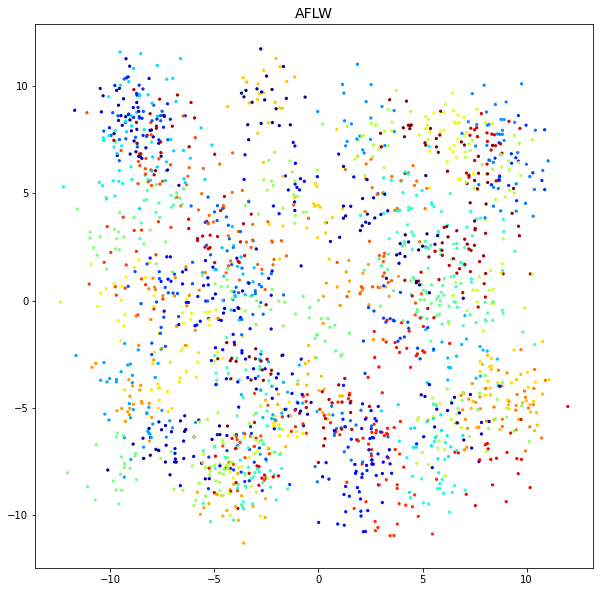

In [7]:
# Plot see the brief clusters 
plt.figure(figsize=(10,10))
plt.scatter(X_a[:, 0], X_a[:, 1], c=y_a, s=5, cmap='jet')
plt.title("AFLW", fontsize=14)
plt.show()

**plot the elbow graph to show the best K**

In [0]:
kmeans_a =[KMeans(n_clusters=k, random_state=42).fit(X_a) for k in range(10,150,10)]
inertias_a = [model.inertia_ for model in kmeans_a]

Text(0.5, 1.0, 'K - Elbow')

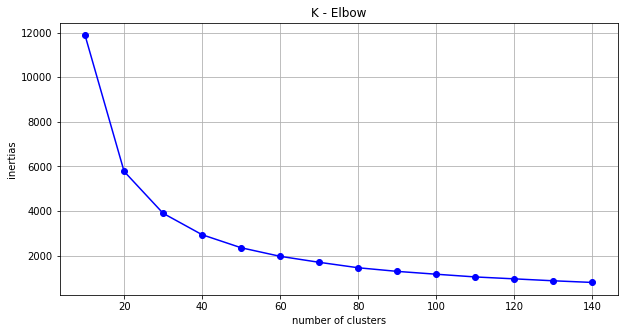

In [9]:
ax=plt.figure(figsize=(10,5))
plt.plot(range(10,150,10),inertias_a,"bo-")
plt.xlabel("number of clusters")
plt.ylabel("inertias")
plt.grid(True)
#plt.vlines(100,0,np.max(inertias_a),color='red')
plt.title("K - Elbow")

**As you can see, the intertia drops very quickly as we increase k up to 20,but then it decreases much more slowly as we keep increasing k. This curve has roughly the shape of an arm, and there is an "elbow "at K=20 so if we did not know better, it would be a good choice: any lower value would be dramatic, while any higher value would not help much, and we might just be splitting perfectly good clusters.**

**K-Means Clustering**
Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=20, random_state=42)

In [0]:
y = kmodel.fit_predict(X_a)

In [12]:
y

array([18,  1,  9, ...,  8,  3, 10], dtype=int32)

In [13]:
len(y)

2000

In [14]:
y is kmodel.labels_

True

Therefore, y is the label (1, 2,..,20) tha represents for each cluster.

**Decision Boundaries**
Let's plot the model's decision boundaries. This gives us a Voronoi diagram:

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

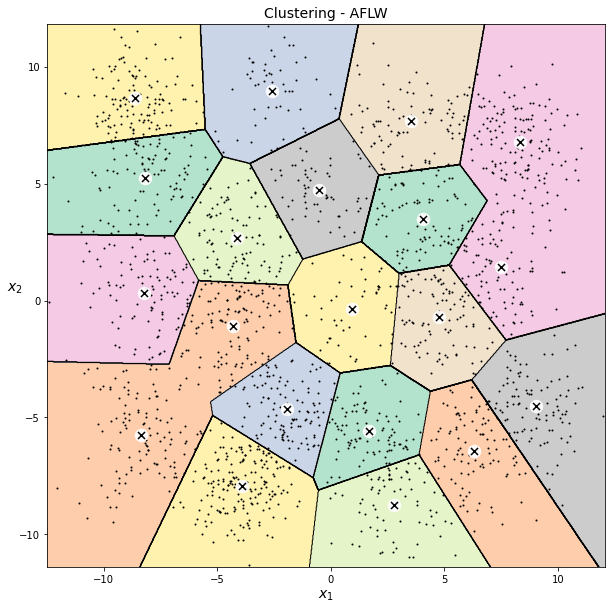

In [16]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(kmodel, X_a)
plt.title("Clustering - AFLW", fontsize=14)
plt.show()

**Evaluating clusters (built by kmean) using Random Forest**


RandomForest Classifier
Spliting data
training and testing set in ratio 70%-30%

In [0]:
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y, test_size=0.3, shuffle = True, random_state=42)

In [18]:
X_a_train.shape, X_a_test.shape, y_a_train.shape, y_a_test.shape

((1400, 2), (600, 2), (1400,), (600,))

In [0]:
RF_a = RandomForestClassifier()


Performimng Cross Validation with a subset size of 500

In [20]:
cross_val_score(RF_a, X_a[:500], y[:500], cv=3, scoring='accuracy').mean()

0.9259673424235867

Create model for fit in Training Set

In [0]:
t0 = time.time()
RF_a.fit(X_a_train, y_a_train)
t1 = time.time()

In [22]:
print("Training took {:.2f}s".format(t1-t0))

Training took 0.24s


Test the model with testing set

In [23]:
RF_a.score(X_a_test, y_a_test)

0.965

In [0]:
y_a_pre= RF_a.predict(X_a)

In [25]:
accuracy_score(y,y_a_pre)

0.9895

See Precision, Recall and F1 report

In [26]:
print(classification_report(y, y_a_pre))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        98
           1       0.98      0.99      0.98        92
           2       0.99      0.99      0.99        88
           3       0.98      0.98      0.98       122
           4       0.99      0.99      0.99       116
           5       1.00      0.98      0.99        99
           6       0.98      1.00      0.99       113
           7       1.00      1.00      1.00        51
           8       1.00      1.00      1.00       100
           9       1.00      0.99      1.00       143
          10       0.99      1.00      0.99        95
          11       0.98      0.99      0.99       100
          12       0.99      0.97      0.98        75
          13       0.98      1.00      0.99        52
          14       0.99      0.98      0.98       184
          15       1.00      0.98      0.99       125
          16       1.00      0.98      0.99        97
          17       0.99    

Because there is fully formed trees in random forest classifier, then it should be able to recreate the rules you ended up clustering by, and accuracy would be near 100%. If you are cutting off the depth of the trees in the random forest (which is pretty standard, let's say you set max_depth = 8), then you will have an accuracy that may be less than 100%.

**Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set.** 


Clustering can be an efficient approach to dimensionality reduction,in particular as a preprocessing step.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
X_train_reduced = scaler.fit_transform(X_a_train)
X_test_reduced = scaler.fit_transform(X_a_test)

In [0]:
km_a=KMeans(n_clusters=20)

In [30]:
cross_val_score(km_a, X_a[:500], y[:500], cv=3, scoring='accuracy').mean()

0.020032224707212082

Search for the number of clusters that provides the best performance.


In [32]:

pipe = Pipeline([
        ("kmeans", KMeans(n_clusters=20, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=20, random_state=42))
    ])
pipe.fit(X_train_reduced, y_a_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=20, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('forest_clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=20, n_jobs=

In [33]:
pipe.score(X_test_reduced, y_a_test)

0.9733333333333334

the best value of K is simply the one that results in the best classification performance during cross-validation.let's use GridSearchCV to find the optimal number of clusters

In [34]:
param_grid = dict(kmeans__n_clusters=range(1, 100))
grid_clf = GridSearchCV(pipe, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train_reduced, y_a_train)

Fitting 3 folds for each of 99 candidates, totalling 297 fits
[CV] kmeans__n_clusters=1 ............................................
[CV] ............................. kmeans__n_clusters=1, total=   0.1s
[CV] kmeans__n_clusters=1 ............................................
[CV] ............................. kmeans__n_clusters=1, total=   0.1s
[CV] kmeans__n_clusters=1 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=1, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 297 out of 297 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=20, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('forest_clf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='

In [35]:
grid_clf.best_params_

{'kmeans__n_clusters': 81}

In [36]:
grid_clf.score(X_test_reduced, y_a_test)

0.9716666666666667

In [0]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
  if axes is None:
        _, axes = plt.subplots(2, 1, figsize=(20, 5))

  axes.set_title(title)
  if ylim is not None:
        axes.set_ylim(*ylim)
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")

  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  axes.grid()
  axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
  axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
  axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
  axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
  axes.legend(loc="best")
  return plt

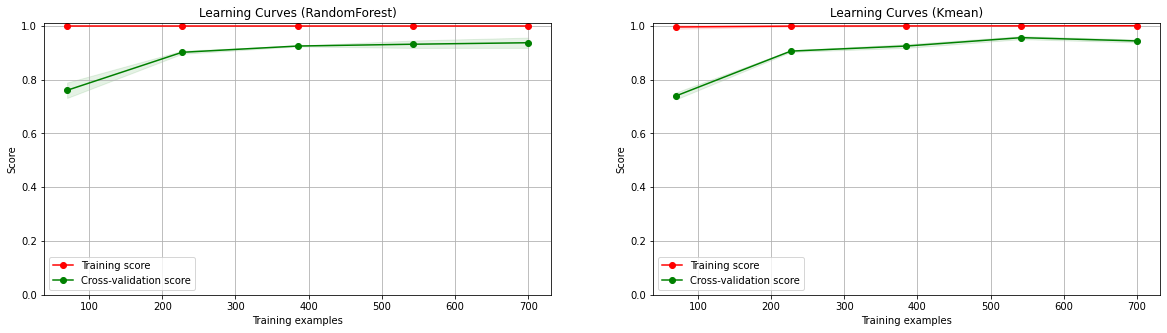

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Cross validation with 3 iterations 
# score curves, each time with 20% data randomly selected as a validation set.

title = "Learning Curves (RandomForest)"
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
plot_learning_curve(RF_a, title, X_a[:1000], y[:1000], axes=axes[0], ylim=(0, 1.01),
                    cv=cv, n_jobs=3)


title = "Learning Curves (Kmean)"
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
plot_learning_curve(pipe, title, X_a[:1000], y[:1000], axes=axes[1], ylim=(0, 1.01),
                    cv=cv,n_jobs=3)
plt.show()

**After use keams as the preprocessing step, we gt a small accuracy boost.**

**Gaussian Mixtures with PCA (99% Variation)**

In [0]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_a)

In [40]:
#Training model
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=81, n_init=10, random_state=42)
gm.fit(X_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=81, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

**Did it actually Converged?**

In [41]:
gm.converged_

True

How many Iteration did it took?

In [42]:
gm.n_iter_

36

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use predict() method or the predict_proba() method:

In [43]:
gm.predict(X_pca)

array([80, 67, 60, ...,  2, 21, 65])

**Plotting the resulting decision boundaries & density contours:**

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

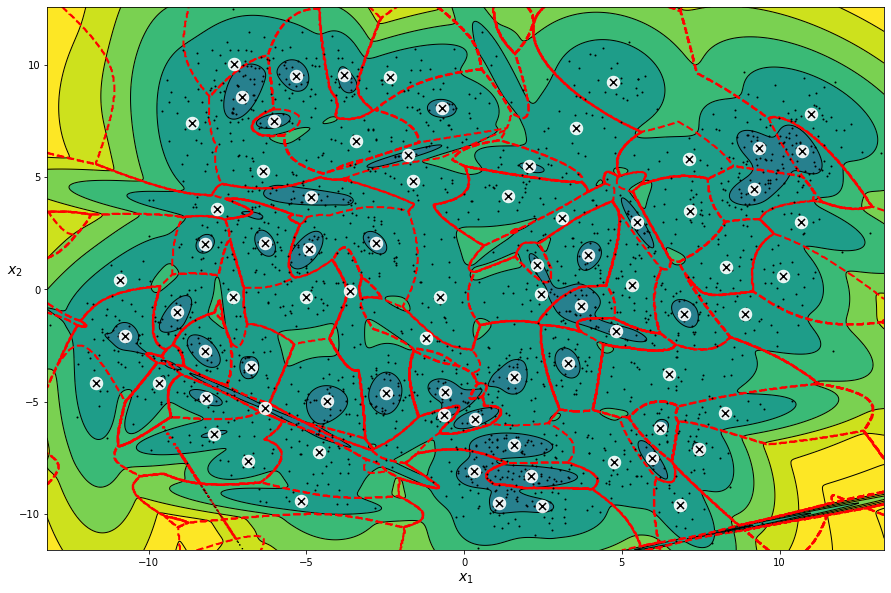

In [48]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm, X_pca)

plt.show()

generate the data using a set of 2D Gaussian distributions, gave the correct number of cluster, 

**Anomaly Detection using Gaussian Mixtures**
Assume the threshold is 10%

In [0]:
densities = gm.score_samples(X_pca)
density_threshold = np.percentile(densities, 10)
anomalies = X_pca[densities < density_threshold]

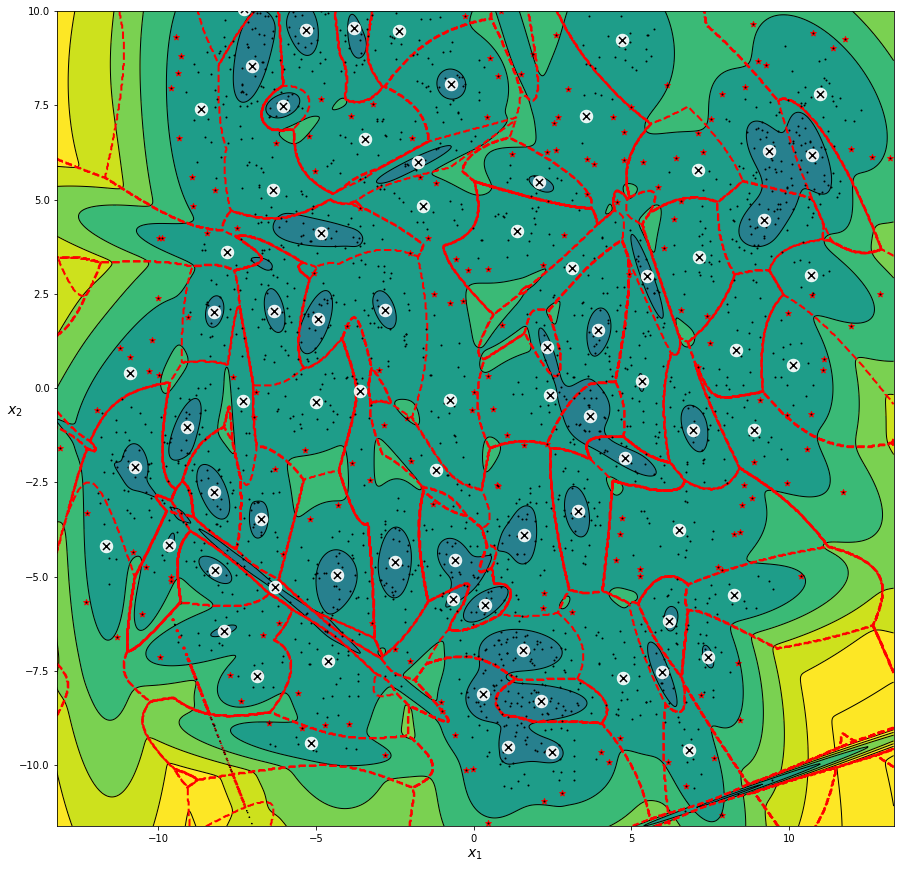

In [47]:
plt.figure(figsize=(15, 15))
plot_gaussian_mixture(gm, X_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=10)
plt.show()